In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
def lagr_interpolate(x, grid, u):
    res = 0
    for m in range(0, len(grid)-2, 2):
        if x <= grid[m+2] and x >= grid[m]:
            for j in range(3):
                prod = 1
                for i in range(3):
                    if i != j:
                        prod *= (x - grid[m+i]) / (grid[m+j] - grid[m+i])
                res += prod*u[m+j]
            return res
        
def fit_interpolate(x, grid, u, eps, fi=lambda x: np.exp(-x/eps)):
    res = 0
    for m in range(0, len(grid)-2, 2):
        if x <= grid[m+2] and x >= grid[m]:
            return u[m] * (x - grid[m+1])/(grid[m] - grid[m+1]) + u[m+1] * (x - grid[m])/(grid[m+1] - grid[m]) + (u[m+2] - 2*u[m+1] + u[m])/(fi(grid[m+2]) - 2*fi(grid[m+1]) + fi(grid[m])) * (fi(x) - fi(grid[m]) * (x - grid[m+1])/(grid[m] - grid[m+1]) + fi(grid[m+1]) * (x - grid[m])/(grid[m+1] - grid[m]))

In [4]:
def get_u(grid, u):
    res = []
    for i in range(len(grid)):
        res.append(u(grid[i]))
    return np.array(res)

def get_lagr(x_points, grid, u):
    res = []
    u_h = get_u(grid, u)
    for i in range(len(x_points)):
        res.append(lagr_interpolate(x_points[i], grid, u_h))
    return np.array(res)

def get_fit(x_points, grid, u, eps, fi=lambda x: np.exp(-x/eps)):
    res = []
    u_h = get_u(grid, u)
    for i in range(len(x_points)):
        res.append(fit_interpolate(x_points[i], grid, u_h, eps, fi))
    return np.array(res)
        
def uniform_grid(a,b,n):
    dots=[]
    for i in range(n+1):
        dots.append(a+(b-a)*i/n)
    return np.array(dots)

def min_(a,b):
    if a > b:
        return b
    else:
        return a

def shishkin_grid(a, b, N, eps):
    sigma = min_(2*eps*np.log(N),0.5)
    res = np.zeros(N+1)
    res[0] = a
    h = 2*sigma/N
    for i in range(1,int(N/2) + 1):
        res[i] = res[i-1] + h
    H = 2*(b-a-sigma)/N
    for i in range(int(N/2) + 1, N+1):
        res[i] = res[i-1] + H
    return res

def bahvalov_grid(N, eps, k=2):
    sigma = min_(0.5, - k * eps * np.log(eps))
    if eps > 1 / np.exp(1):
        sigma = 1/2
    if sigma >= 1/2:
        return uniform_grid(0, 1, N)
    res = []
    for i in range(int(N/2) + 1):
        res.append(- k * eps * np.log(1 - 2*(1 - eps) * i / N))
    for i in range(int(N/2) + 1, N+1):
        res.append(sigma + (2*i/N-1)*(1-sigma) )
    return res
    

def subgrid(grid):
    res = np.array([])
    for m in range(0, len(grid) - 2, 2):
        res = np.concatenate([res, np.delete(uniform_grid(grid[m], grid[m+2], 10), 10)])
    return np.concatenate([res, np.array([grid[len(grid) - 1]])])

def error_norm(f_1, f_2):
    return np.max(np.abs(f_1 - f_2))

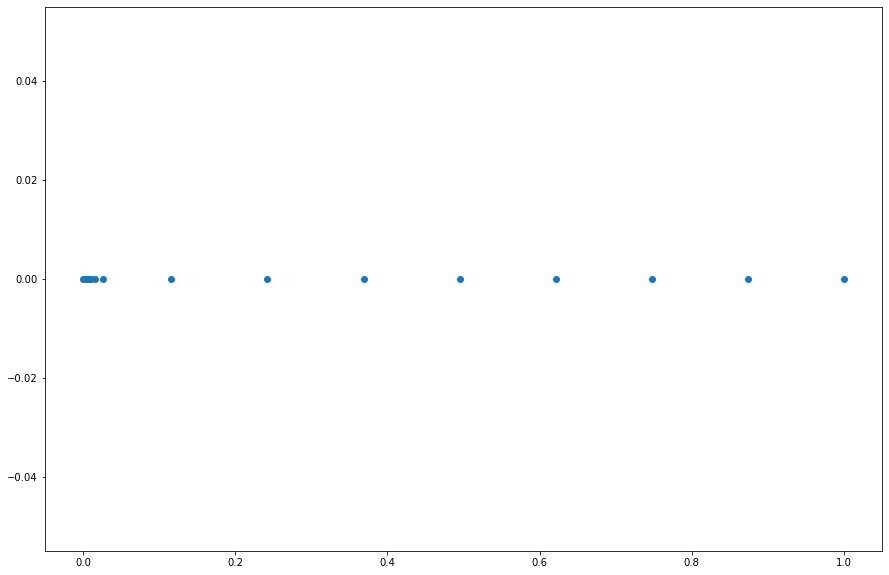

In [9]:
x = bahvalov_grid(15, 0.005)
y = np.zeros(len(x))
plt.figure(figsize=(15, 10))
plt.scatter(x, y)

In [5]:
N = [8, 16, 32, 64, 128, 256, 512, 1024]
eps = [1/8, 1/16, 1/32, 1/64, 1/128, 1/256, 1/512, 1/1024]

In [6]:
# Многочлен Лагражна на равномерной сетке

res_table = np.zeros((len(eps), len(N)))

for i in range(len(eps)):
    for j in range(len(N)):
        grid = uniform_grid(0, 1, N[j])
        x = subgrid(grid)
        u = lambda x: np.cos(np.pi * x / 2) + np.exp(-x/eps[i])
        u_h = get_u(x, u)
        u_lagr = get_lagr(x, grid, u)
        error = error_norm(u_h, u_lagr)
        res_table[i,j] = error
        print("{:.2e}".format(error), end=' ')
    print()

orders = np.zeros((len(eps), len(N)-1))
for j in range(len(N)-1):
    orders[:,j] = np.log2(res_table[:,j] / res_table[:,j+1] )

print("ORDERS:")
for i in range(len(eps)):
    for j in range(len(N)-1):
        print("{:.2e}".format(orders[i,j]),end=' ')
    print()

2.88e-02 5.30e-03 8.11e-04 1.12e-04 1.48e-05 1.90e-06 2.41e-07 3.03e-08 
1.15e-01 2.89e-02 5.30e-03 8.11e-04 1.12e-04 1.48e-05 1.90e-06 2.41e-07 
2.90e-01 1.15e-01 2.89e-02 5.30e-03 8.11e-04 1.12e-04 1.48e-05 1.90e-06 
5.18e-01 2.90e-01 1.15e-01 2.89e-02 5.30e-03 8.11e-04 1.12e-04 1.48e-05 
6.79e-01 5.18e-01 2.90e-01 1.15e-01 2.89e-02 5.30e-03 8.11e-04 1.12e-04 
7.18e-01 6.79e-01 5.18e-01 2.90e-01 1.15e-01 2.89e-02 5.30e-03 8.11e-04 
7.20e-01 7.18e-01 6.79e-01 5.18e-01 2.90e-01 1.15e-01 2.89e-02 5.30e-03 
7.20e-01 7.20e-01 7.18e-01 6.79e-01 5.18e-01 2.90e-01 1.15e-01 2.89e-02 
ORDERS:
2.44e+00 2.71e+00 2.85e+00 2.92e+00 2.96e+00 2.98e+00 2.99e+00 
1.99e+00 2.45e+00 2.71e+00 2.85e+00 2.92e+00 2.96e+00 2.98e+00 
1.33e+00 1.99e+00 2.45e+00 2.71e+00 2.85e+00 2.92e+00 2.96e+00 
8.38e-01 1.33e+00 1.99e+00 2.45e+00 2.71e+00 2.85e+00 2.92e+00 
3.90e-01 8.39e-01 1.33e+00 1.99e+00 2.45e+00 2.71e+00 2.85e+00 
8.06e-02 3.90e-01 8.39e-01 1.33e+00 1.99e+00 2.45e+00 2.71e+00 
3.22e-03 8.07e-02 3.90e-

In [7]:
# Многочлен Лагранжа на сетке Шишкина

res_table = np.zeros((len(eps), len(N)))

for i in range(len(eps)):
    for j in range(len(N)):
        grid = shishkin_grid(0, 1, N[j], eps[i])
        x = subgrid(grid)
        u = lambda x: np.cos(np.pi * x / 2) + np.exp(-x/eps[i])
        u_h = get_u(x, u)
        u_lagr = get_lagr(x, grid, u)
        error = error_norm(u_h, u_lagr)
        res_table[i,j] = error
        print("{:.2e}".format(error), end=' ')
    print()
    
orders = np.zeros((len(eps), len(N)-1))
for j in range(len(N)-1):
    orders[:,j] = np.log2(res_table[:,j] / res_table[:,j+1] )

print("ORDERS:")
for i in range(len(eps)):
    for j in range(len(N)-1):
        print("{:.2e}".format(orders[i,j]),end=' ')
    print()

2.88e-02 5.30e-03 8.11e-04 1.12e-04 1.48e-05 1.90e-06 2.41e-07 3.03e-08 
3.15e-02 1.21e-02 3.64e-03 8.11e-04 1.12e-04 1.48e-05 1.90e-06 2.41e-07 
3.15e-02 1.21e-02 3.64e-03 9.05e-04 1.96e-04 3.87e-05 7.11e-06 1.24e-06 
3.15e-02 1.21e-02 3.64e-03 9.05e-04 1.96e-04 3.87e-05 7.11e-06 1.24e-06 
3.15e-02 1.21e-02 3.64e-03 9.05e-04 1.96e-04 3.87e-05 7.11e-06 1.24e-06 
3.15e-02 1.21e-02 3.64e-03 9.05e-04 1.96e-04 3.87e-05 7.11e-06 1.24e-06 
3.15e-02 1.21e-02 3.64e-03 9.05e-04 1.96e-04 3.87e-05 7.11e-06 1.24e-06 
3.15e-02 1.21e-02 3.64e-03 9.05e-04 1.96e-04 3.87e-05 7.11e-06 1.24e-06 
ORDERS:
2.44e+00 2.71e+00 2.85e+00 2.92e+00 2.96e+00 2.98e+00 2.99e+00 
1.38e+00 1.74e+00 2.16e+00 2.85e+00 2.92e+00 2.96e+00 2.98e+00 
1.38e+00 1.74e+00 2.01e+00 2.20e+00 2.34e+00 2.44e+00 2.52e+00 
1.38e+00 1.74e+00 2.01e+00 2.20e+00 2.34e+00 2.44e+00 2.52e+00 
1.38e+00 1.74e+00 2.01e+00 2.20e+00 2.34e+00 2.44e+00 2.52e+00 
1.38e+00 1.74e+00 2.01e+00 2.20e+00 2.34e+00 2.44e+00 2.52e+00 
1.38e+00 1.74e+00 2.01e+

In [8]:
# Многочлен Лагранжа на сетке Бахвалова

res_table = np.zeros((len(eps), len(N)))

for i in range(len(eps)):
    for j in range(len(N)):
        grid = bahvalov_grid(N[j], eps[i], k = 4)
        x = subgrid(grid)
        u = lambda x: np.cos(np.pi * x / 2) + np.exp(-x/eps[i])
        u_h = get_u(x, u)
        u_lagr = get_lagr(x, grid, u)
        error = error_norm(u_h, u_lagr)
        res_table[i,j] = error
        print("{:.2e}".format(error), end=' ')
    print()
    
orders = np.zeros((len(eps), len(N)-1))
for j in range(len(N)-1):
    orders[:,j] = np.log2(res_table[:,j] / res_table[:,j+1] )

print("ORDERS:")
for i in range(len(eps)):
    for j in range(len(N)-1):
        print("{:.2e}".format(orders[i,j]),end=' ')
    print()

2.88e-02 5.30e-03 8.11e-04 1.12e-04 1.48e-05 1.90e-06 2.41e-07 3.03e-08 
1.15e-01 2.89e-02 5.30e-03 8.11e-04 1.12e-04 1.48e-05 1.90e-06 2.41e-07 
2.90e-01 1.15e-01 2.89e-02 5.30e-03 8.11e-04 1.12e-04 1.48e-05 1.90e-06 
5.20e-02 6.93e-03 9.09e-04 1.16e-04 1.47e-05 1.85e-06 2.32e-07 3.37e-08 
6.18e-02 7.09e-03 9.31e-04 1.19e-04 1.51e-05 1.90e-06 2.38e-07 2.98e-08 
7.44e-02 7.17e-03 9.42e-04 1.21e-04 1.53e-05 1.92e-06 2.41e-07 3.01e-08 
8.77e-02 7.21e-03 9.47e-04 1.21e-04 1.53e-05 1.93e-06 2.42e-07 3.03e-08 
1.01e-01 7.23e-03 9.50e-04 1.22e-04 1.54e-05 1.94e-06 2.43e-07 3.04e-08 
ORDERS:
2.44e+00 2.71e+00 2.85e+00 2.92e+00 2.96e+00 2.98e+00 2.99e+00 
1.99e+00 2.45e+00 2.71e+00 2.85e+00 2.92e+00 2.96e+00 2.98e+00 
1.33e+00 1.99e+00 2.45e+00 2.71e+00 2.85e+00 2.92e+00 2.96e+00 
2.91e+00 2.93e+00 2.97e+00 2.98e+00 2.99e+00 3.00e+00 2.79e+00 
3.12e+00 2.93e+00 2.96e+00 2.98e+00 2.99e+00 3.00e+00 3.00e+00 
3.38e+00 2.93e+00 2.96e+00 2.98e+00 2.99e+00 3.00e+00 3.00e+00 
3.60e+00 2.93e+00 2.96e+